In [1]:
# Reading csv
import pandas as pd
 
cases = pd.read_csv('case_reversed.csv')
cases.head()

,caseid,case_reversed
0,X3JGGO,0
1,X3OH3J,0
2,X3U0KO,0
3,X53HAD,0
4,X9VC5V,0


In [2]:
# Reading documents
from glob import glob
import spacy
import numpy as np

doc_num = len(cases)
N_files = 1000

fnames = np.random.permutation(glob('cases/*txt'))[:N_files]

nlp = spacy.load('en')

processed = {}

iteration = 1

# iterate over all files
for fname in fnames:
    docid = fname.split('\\')[-1][5:-4] # cut filepath and extension
    year = fname.split('\\')[-1][:4]
    if iteration % (N_files//10) == 0:
        print(str(100*iteration/N_files) + "%")
    iteration = iteration + 1
    text = open(fname,'r', encoding='utf8').read() # read file as string
    doc=nlp(text)
    sentences = []
    token_num = 0
    letter_num = 0
    for sent in doc.sents:
        tokens = []
        for token in sent:
            # remove spaces and punctuation
            if token.is_space == False and token.is_punct == False: 
                tokens.append(token)    
                letter_num = letter_num + len(token) 
        sentences.append(tokens)
        token_num = token_num + len(tokens) 
    # format of dictionary processed:    
    # 0 senrences-tokens, 1 year, 2 [number of sentences, number of tokens, number of letters], 
    # 3 [number of nouns, number of verbs, number of adjectives], 4 normalized text, 5 features, 6 reversed]
    processed[docid] = [sentences,year,[len(sentences),token_num,letter_num],[],[],[],[]]

10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%


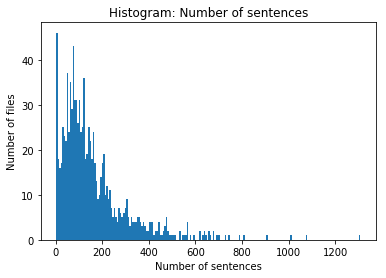

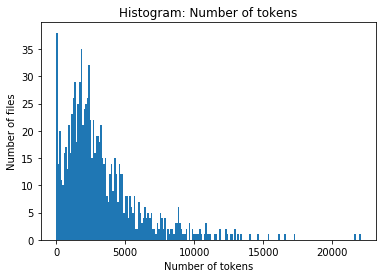

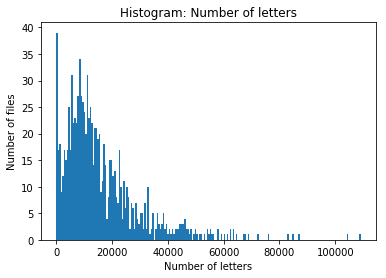

In [21]:
# Plotting histograms of number of sentences, tokens and letters
import matplotlib.pyplot as plt

numbers_of_sentences=[v[2][0] for k,v in processed.items()]
plt.hist(numbers_of_sentences, bins=N_files//5)
plt.title('Histogram: Number of sentences')
plt.xlabel('Number of sentences')
plt.ylabel('Number of files')
plt.show()

numbers_of_tokens=[v[2][1] for k,v in processed.items()]
plt.hist(numbers_of_tokens, bins=N_files//5)
plt.title('Histogram: Number of tokens')
plt.xlabel('Number of tokens')
plt.ylabel('Number of files')
plt.show()

numbers_of_letters=[v[2][2] for k,v in processed.items()]
plt.hist(numbers_of_letters, bins=N_files//5)
plt.title('Histogram: Number of letters')
plt.xlabel('Number of letters')
plt.ylabel('Number of files')
plt.show()

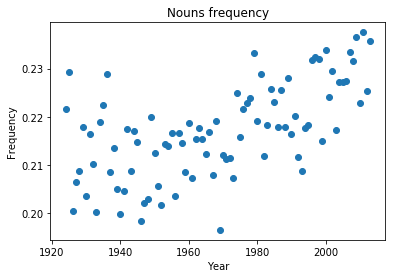

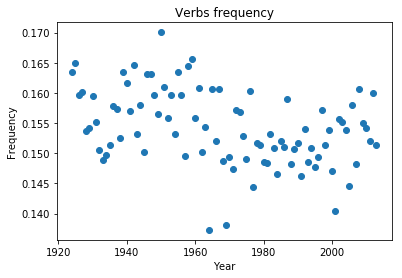

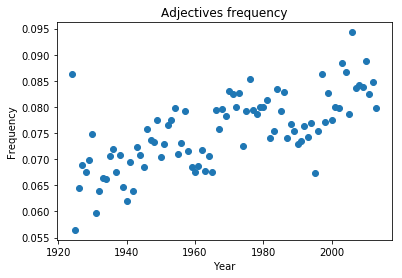

In [4]:
# Counting nouns, verbs and adjectives

# Dictionary that has years as keys
pos_counts={}

for k,v in processed.items():    
    noun_num = 0
    verb_num = 0
    adj_num = 0
    for s in v[0]:
        for t in s:
            if t.pos_ == 'NOUN':
                noun_num = noun_num + 1
            if t.pos_ == 'VERB':
                verb_num = verb_num + 1
            if t.pos_ == 'ADJ':
                adj_num = adj_num + 1
    processed[k][3]=[noun_num,verb_num,adj_num]
    if v[1] in pos_counts:
        pos_counts[v[1]] = pos_counts[v[1]] + [noun_num,verb_num,adj_num,v[2][1]]
    else:
        pos_counts[v[1]] = np.array([noun_num,verb_num,adj_num,v[2][1]])
        
noun_freq = []
verb_freq = []
adj_freq = []
year_freq = [] 
for k,v in pos_counts.items():
    # frequency is computed as number of watched tokens devided by number of all tokens
    noun_freq.append(v[0]/v[3])
    verb_freq.append(v[1]/v[3])
    adj_freq.append(v[2]/v[3])
    # save year for x axis
    year_freq.append(int(k))
    
plt.plot(year_freq,noun_freq,'o')
plt.title('Nouns frequency')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

plt.plot(year_freq,verb_freq,'o')
plt.title('Verbs frequency')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

plt.plot(year_freq,adj_freq,'o')
plt.title('Adjectives frequency')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

In [5]:
# Normalizing text

stopwords = spacy.lang.en.stop_words.STOP_WORDS

features = []

for k,v in processed.items():  
    normalized=[]
    for s in v[0]:
        sent = []
        for t in s:
            # removing stopwords and digits
            if not(t.lower_ in stopwords) and not(t.is_digit):
                sent.append(t)
        if not sent == []:         
            if len(sent) >= 3:
                for i in range(len(sent)-2):
                    f = [sent[i].lemma_,sent[i+1].lemma_,sent[i+2].lemma_]
                    # finding trigrams that ends with a noun
                    if sent[i+2].pos_=='NOUN' and not f in features:
                        features.append(f)
            sent2=[]
            for t in sent:
                # lemmatize tokens
                sent2.append(t.lemma_)
            normalized.append(sent2)
            
    processed[k][4] = normalized

In [6]:
# Taking N_features random selected features from all found features
N_features = 1000

features = list(np.random.permutation(features)[:N_features]) 

# Computing standardized features for each document

f_mean = np.zeros(N_features)

for k,v in processed.items():  
    f_num = np.zeros(N_features)
    for f in range(N_features):
        for s in v[4]:
            for i in range(len(s)-2):
                if s[i:i+3]==list(features[f]):
                    f_num[f] = f_num[f] + 1
    processed[k][5] = f_num
    f_mean = f_mean + f_num

# feature mean value    
f_mean = f_mean / N_files

# computing standard deviation
f_var = np.zeros(N_features)

for k,v in processed.items():  
    f_var = f_var + (v[5] - f_mean)**2
    
f_var = np.sqrt(f_var)

# standardize features of each document
for k,v in processed.items():  
    processed[k][5] = processed[k][5] / f_var

In [7]:
# Adding indicator case_reversed
# Making list of inputs and outputs of ML algorithm
x_input = []
y_output = []
for k in range(len(cases['caseid'])):
    if cases['caseid'][k] in processed.keys():
        processed[cases['caseid'][k]][6] = cases['case_reversed'][k]
        x_input.append(processed[cases['caseid'][k]][5])
        y_output.append(processed[cases['caseid'][k]][6])

In [24]:
# Spliting data into training and test set
from sklearn.utils import shuffle

x_input, y_output = shuffle(x_input, y_output)

train_percent = 0.7
x_train, x_test = x_input[:int(train_percent*len(x_input))], x_input[int(train_percent*len(x_input)):]
y_train, y_test = y_output[:int(train_percent*len(y_output))], y_output[int(train_percent*len(y_output)):]


In [25]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(x_train, y_train)

In [27]:
# Accuracy
print("Accuracy, train set: " + str(clf.score(x_train, y_train)))
print("Accuracy, test set: " + str(clf.score(x_test, y_test)))

# F1 score
from sklearn.metrics import f1_score

print("F1 score, train set: " + str(f1_score(y_train, clf.predict(x_train))))
print("F1 score, test set: " + str(f1_score(y_test, clf.predict(x_test))))

Accuracy, train set: 0.7185714285714285
Accuracy, test set: 0.59
F1 score, train set: 0.8194317140238313
F1 score, test set: 0.7421383647798743


In [28]:
# Searching for best model parameters and score
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression()
param_grid = {'C': np.logspace(0, 4, 100), 'penalty': ['l1', 'l2']}
clf_gs = GridSearchCV(lr, param_grid, cv=5, verbose=0)
best_model = clf_gs.fit(x_train, y_train)

print("Best model parameters " + str(clf_gs.best_params_))
print("Best model score " + str(clf_gs.best_score_))

Best model parameters {'C': 2.3101297000831598, 'penalty': 'l2'}
Best model score 0.64


In [12]:
# New dataframe 

new_data = []

for k,v in processed.items():
    for s in processed[k][0]:
        new_sent = ""
        for t in s:
            new_sent = new_sent + str(t)
            if not t == s[-1]:
                new_sent = new_sent + " "
        new_data.append(new_sent)

print(new_data[:3])

['McGOWAN Circuit Judge This is an appeal from a judgment of the District Court enjoining the enforcement at the Marine Corps Air Station in Iwakuni Japan of certain Marine Corps and Navy regulations which require prior approval for the circulation by military personnel of inter alia petitions to members of Congress', '413 F.Supp', '863 1976']


In [13]:
# Vader compound sentiment score
from nltk.sentiment.vader import SentimentIntensityAnalyzer

vader = []

sid = SentimentIntensityAnalyzer()
for sentence in new_data:
    ss = sid.polarity_scores(sentence)
    vader.append(ss['compound'])

C:\Users\lazar\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [14]:
# Reporting sentences with highest and lowest vader compounds

#vader.sort()
vader_ind = np.argsort(vader)

print("---------- Lowest-sentiment sentences ----------")
print()
for i in range(10):
    print("Vader compound sentiment score = " + str(vader[vader_ind[i]]))
    print(new_data[vader_ind[i]])
    print()

print()
print("---------- Highest-sentiment sentences ----------")
print()
for i in range(10):
    print("Vader compound sentiment score = " + str(vader[vader_ind[-i-1]]))
    print(new_data[vader_ind[-i-1]])
    print()

---------- Lowest-sentiment sentences ----------

Vader compound sentiment score = -0.9924
Under Virginia law the death penalty may be imposed upon a defendant if the jury finds beyond a reasonable doubt that there is a probability based upon evidence of the prior history of the defendant or of the circumstances surrounding the commission of the offense of which he is accused that he would commit criminal acts of violence that would constitute a continuing serious threat to society the dangerousness criterion or that his conduct in committing the offense was outrageously or wantonly vile horrible or inhuman in that it involved torture depravity of mind or aggravated battery to the victim the vileness criterion Va

Vader compound sentiment score = -0.9921
See e.g. Correll 465 F.3d at 1015 involving three murders and one failed attempted murder Mayfield 270 F.3d at 920 21 932 involving two murders and one attempted murder Wallace 184 F.3d at 1113 1118 involving two murders and two attemp

It also charged conversion by the Trust Company of property of the Belt Company also that the Trust Company occupied a fiduciary relation to the Belt Company and by reason thereof had no right to charge any sums as profits that the Trust Company in pursuance of a fraudulent plan sold worthless securities to the Belt Company that the Trust Company fraudulently made overcharges on its books against a subsidiary company of the Belt Company which charges afterward became charges against the Belt Company that the Trust Company made sales of stocks and bonds for the Belt Company and reported the same as made at less than the actual figures thereby securing for itself a profit that the Trust Company caused the Belt Company to declare and pay dividends when it was insolvent and that the Trust Company as a stockholder in the Belt Company received such dividends that the Trust Company caused the Union Terminal Company whose stock was owned by the Belt Company to issue bonds and deliver the same 

In [15]:
# TD-IDF frequencies
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
# sparse matrix that represents tf-idf frequencies where 
# rows denotes documents and columns denotes words
X = vectorizer.fit_transform(new_data)
print(X)
# np.shape(X) # number of documents x number of words
# print(vectorizer.get_feature_names()) # all words
 

  (0, 25153)	0.21714835112636421
  (0, 10071)	0.11456016066787367
  (0, 22373)	0.10730850189595456
  (0, 37760)	0.07300196992199628
  (0, 22012)	0.06263199735256798
  (0, 5764)	0.07734639536356315
  (0, 6048)	0.11352094578040346
  (0, 17757)	0.08137638166399057
  (0, 22381)	0.10776323832147056
  (0, 27655)	0.16275538973161377
  (0, 37663)	0.1366801677285556
  (0, 14061)	0.08586987438166906
  (0, 11896)	0.06670415366789303
  (0, 15392)	0.19053498596606988
  (0, 15344)	0.1376498110787727
  (0, 6605)	0.06894206509446353
  (0, 24781)	0.3567058677978622
  (0, 11705)	0.3539740746213942
  (0, 5321)	0.1575727327417715
  (0, 36002)	0.17033272330714075
  (0, 20783)	0.04821066574578368
  (0, 22110)	0.23335762658126646
  (0, 22180)	0.2009886721275257
  (0, 9647)	0.1286190308331745
  (0, 5814)	0.04988204093917797
  :	:
  (160156, 5079)	0.3220957741746745
  (160157, 22012)	0.0972701523835512
  (160157, 37663)	0.26533763301380714
  (160157, 6605)	0.10706995562708523
  (160157, 5814)	0.077468928478255

In [20]:
# Cosine similarity

from sklearn.metrics.pairwise import cosine_similarity

# cosine similarity is computed on a subset of X, because otherwise it gives memory error
cos_sim = cosine_similarity(X[:100])
print(cos_sim)

# excluding diagonal
np.fill_diagonal(cos_sim,0)

row=np.argmax(cos_sim,axis=0)
column=np.argmax(np.max(cos_sim,axis=0))
sim_max_1 = row[column]
sim_max_2 = column
print()
print("Example of very similar sentences")
print(new_data[sim_max_1])
print()
print(new_data[sim_max_2])
print()

# excluding diagonal
np.fill_diagonal(cos_sim,1)

row=np.argmin(cos_sim,axis=0)
column=np.argmin(np.min(cos_sim,axis=0))
sim_min_1 = row[column]
sim_min_2 = column
print()
print("Example of very dissimilar sentences")
print(new_data[sim_min_1])
print()
print(new_data[sim_min_2])

[[1.         0.         0.         ... 0.1753895  0.08227007 0.12863142]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.1753895  0.         0.         ... 1.         0.25424939 0.13705449]
 [0.08227007 0.         0.         ... 0.25424939 1.         0.16286753]
 [0.12863142 0.         0.         ... 0.13705449 0.16286753 1.        ]]

Example of very similar sentences
The particular guidelines which armed forces personnel have set down to guide commanding officers in granting or denying requests to distribute assume relevance only if it is first determined that the basic system of prior approval for any petitioning activity is itself necessary to the security of the United States

Rather than determining whether the system of prior restraint in the particular circumstances before them is within the national security exception to 1034 these courts have measured the standard of nat

In [17]:
# K-means clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20, random_state=0).fit(X)

In [18]:
# Reporting examples from each cluster
for i in range(20):
    n_elem = 0
    print("---------- Class " + str(i+1) + " ----------")
    for j in range(len(kmeans.labels_)):
        if kmeans.labels_[j] == i:
            n_elem = n_elem + 1
            print(new_data[j])
            print()
        if n_elem == 5:
            print()
            break
            

---------- Class 1 ----------
OPINION ERVIN Chief Judge

COLEMAN Circuit Judge

KEARSE Circuit Judge

JOHNSON District Judge

HAMLEY Circuit Judge


---------- Class 2 ----------
Finding as we do that prior restraint in such a case is at odds with the statutory command of Congress we believe the essential grievance suffered in this case is met by limiting declaratory and injunctive relief to the petitioning context

We think the legislative history indeed leaves no doubt that the right to present a solitary individual grievance to a member of Congress is encompassed by 1034

We agree with the Secretary of Defense that 1034 protects also the right to petition members of Congress

We note that this is not the way that courts in the two other cases involving the facial validity of similar military restrictions on petitions have framed the statutory question before them

We emphasize again that when Congress prohibited restrictions on communications with Congress it clearly intended this p

Appellees in this case blocked in their attempts to petition the Congress sought in aid of those attempts to point out that refusal to allow such petitions appeared to violate the principles stated in the Declaration


---------- Class 17 ----------
disables a military commander from acting to avert what he perceives to be a clear danger to the loyalty discipline or morale of troops on the base under his command i d

Four months thereafter following several adjournments of sentencing he moved to withdraw the guilty plea on the grounds that he had subsequently cooperated with and been of assistance to governmental authorities

In the alternative he sought recovery under the Oregon Wrongful Death Act

He therefore determined that it was necessary to take soundings in bay 9 for the purpose of establishing the true cross section of the ogee at that time

He occupied a nonsupervisory capacity and had no control with respect to the manner in which the sounding operation was to be conducted

